# Steam Reviews - Sentiment Analysis ([GitHub](https://github.com/NaufalHD12))

## Project Domain
### Background Problem
Video games have become a major form of entertainment worldwide, with millions of users sharing opinions and reviews online. However, the sheer volume of reviews makes it challenging for potential buyers to gauge the overall sentiment and quality of a game. Users need a way to quickly understand the general sentiment of reviews to make informed purchasing decisions.

### Why and How Should This Problem be Solved?
Analyzing the sentiment of game reviews can help users make better purchasing decisions by summarizing the general opinion of the gaming community. Implementing machine learning models to classify reviews as positive or negative can assist in automating this process. This can be achieved through various models like logistic regression, naive Bayes, SVM, and deep learning approaches such as CNN-BiGRU.

### Research Findings
Studies in sentiment analysis demonstrate that machine learning models, particularly those using deep learning techniques, can effectively classify text sentiment and provide valuable insights across various domains. These models have shown significant success in applications like product reviews, social media analysis, and more. Leveraging these techniques for game reviews can enhance user experience by providing quick and accurate sentiment summaries, which can aid in decision-making and improve overall satisfaction.

**References**:
- https://ieeexplore.ieee.org/document/7820662 
- https://doi.org/10.48550/arXiv.1801.07883

## Business Understanding
### Problem Statements
- How can we efficiently classify game reviews as positive or negative to assist users in decision-making?
- What machine learning models can provide accurate sentiment analysis for game reviews?
### Goals
- Develop machine learning models (logistic regression, naive Bayes, SGD Classifier, and CNN-BiGRU) to classify game reviews.
- Achieve a high accuracy rate with minimum 80% accuracy test to ensure reliable insights for users.

## Data Understanding
### Dataset Overview
- **Link to the dataset**: https://www.kaggle.com/datasets/filipkin/steam-reviews
- **Number of Rows**: 201,151
- **Number of Columns**: 5

### Data Condition
The dataset contains reviews with the following columns:
- id: Unique identifier for each review.
- app_id: Identifier for the game.
- content: The text of the review (note that there are some missing values).
- author_id: Identifier for the author of the review.
- is_positive: Label indicating whether the review is positive or negative.

The content column has some missing values, which need to be addressed during data preprocessing. The sentiment labels are stored as strings in the is_positive column and will need to be converted to a binary format for modeling.
### Exploratory Data Analysis

#### Data Loading

In [1]:
# import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import tensorflow as tf

In [2]:
data = pd.read_csv('steam_data/output.csv')
data.head()

,id,app_id,content,author_id,is_positive
0,181331361,100,At least its a counter strike -1/100,76561199556485100,Negative
1,180872601,100,Uh... So far my playthrough has not been great...,76561199230620391,Negative
2,177836246,100,Better mechanics than cs2,76561198417690647,Negative
3,177287444,100,buggy mess and NOT fun to play at all,76561199077268730,Negative
4,176678990,100,"Whoever came up with this, is gonna fucking ge...",76561199104544266,Negative


#### Initial Inspection
In this section I perform initial inspection to find out general information using **info()** and descriptive statistics using **describe()** on the dataset.

In [3]:
print('Game Reviews Data:')
data.info()

Game Reviews Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201151 entries, 0 to 201150
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           201151 non-null  int64 
 1   app_id       201151 non-null  int64 
 2   content      200723 non-null  object
 3   author_id    201151 non-null  int64 
 4   is_positive  201151 non-null  object
dtypes: int64(3), object(2)
memory usage: 7.7+ MB


In [4]:
data.describe()

,id,app_id,author_id
count,2.011510e+05,201151.000000,2.011510e+05
mean,1.224624e+08,452.899722,7.656120e+16
std,5.896154e+07,322.187389,5.423023e+08
min,2.090000e+02,10.000000,7.656120e+16
25%,7.292665e+07,240.000000,7.656120e+16
50%,1.479831e+08,440.000000,7.656120e+16
75%,1.690541e+08,620.000000,7.656120e+16
max,1.822350e+08,1930.000000,7.656120e+16


#### Data Cleaning

In [5]:
print(data.isnull().sum())

id               0
app_id           0
content        428
author_id        0
is_positive      0
dtype: int64


In [6]:
# Drop rows with missing content
data = data.dropna(subset=['content'])

**Distribution of sentiments**

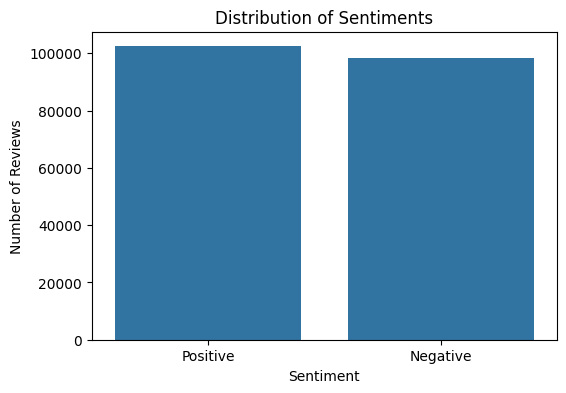

In [8]:
sentiment_counts = data['is_positive'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

The bar chart illustrates the distribution of sentiments in game reviews, highlighting a nearly balanced dataset with slightly more positive reviews than negative ones. This balance is beneficial for training machine learning models, as it helps avoid bias towards one sentiment class. A balanced dataset ensures that the model can learn and predict both positive and negative sentiments effectively, leading to more accurate sentiment analysis.

**Review length distribution**

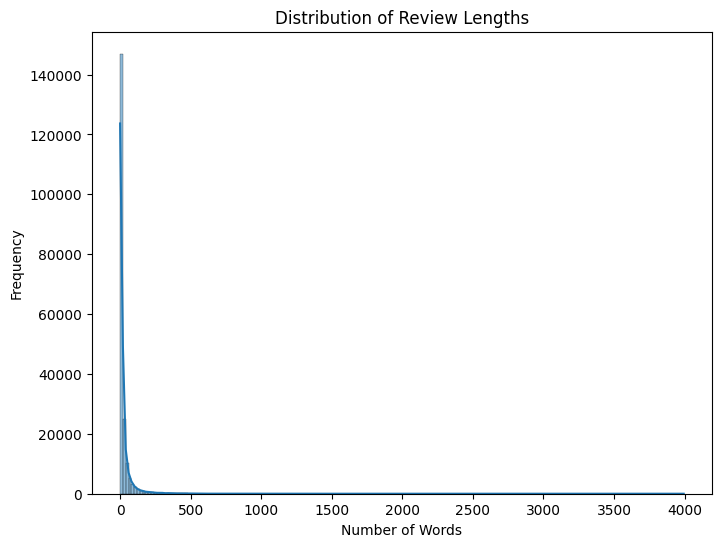

In [67]:
data['review_length'] = data['content'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(data['review_length'], bins=200, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

The histogram of review lengths reveals a highly skewed distribution, where the majority of reviews are relatively short, with a sharp decline in frequency as the word count increases. This indicates that most users prefer concise reviews, with only a few opting for more detailed feedback. For sentiment analysis, this insight suggests the importance of focusing on preprocessing techniques that handle short texts effectively, such as padding or truncating sequences to a standard length.

In [10]:
data['is_positive'] = data['is_positive'].map({'Positive': 1, 'Negative': 0})

In [11]:
# Check unique values in `is_positive`
print(data['is_positive'].unique())

[0 1]


In [12]:
import nltk
from nltk.corpus import stopwords
import pandas as pd

In [13]:
nltk.download('stopwords')

# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a sentence
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hadin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    return text

# Clean the content
data['clean_content'] = data['content'].apply(clean_text)

In [15]:
data['clean_content'] = data['clean_content'].apply(remove_stopwords)

In [16]:
# Most common words in positive and negative reviews
positive_reviews = ' '.join(data[data['is_positive'] == 1]['clean_content'])
negative_reviews = ' '.join(data[data['is_positive'] == 0]['clean_content'])


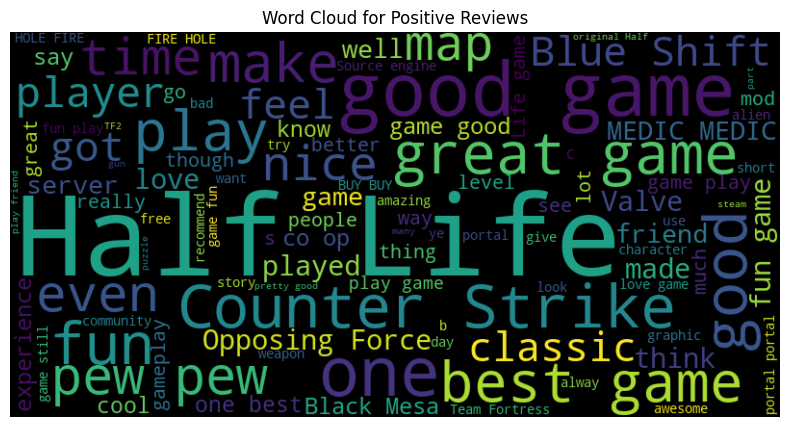

In [17]:
from wordcloud import WordCloud
# Word cloud for positive reviews
wordcloud_pos = WordCloud(width=800, height=400, max_words=100).generate(positive_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

The word cloud for positive reviews highlights key terms that frequently appear in favorable feedback, such as "Half-Life," "Counter-Strike," "fun," "great," and "best." These prominent words suggest that players often associate positive experiences with specific games and enjoyable gameplay elements. The presence of words like "classic" and "love" indicates a strong nostalgic or emotional connection to these games. This insight can guide developers and marketers in understanding what aspects of a game resonate well with players, potentially informing future game development and promotional strategies to emphasize these positive attributes.

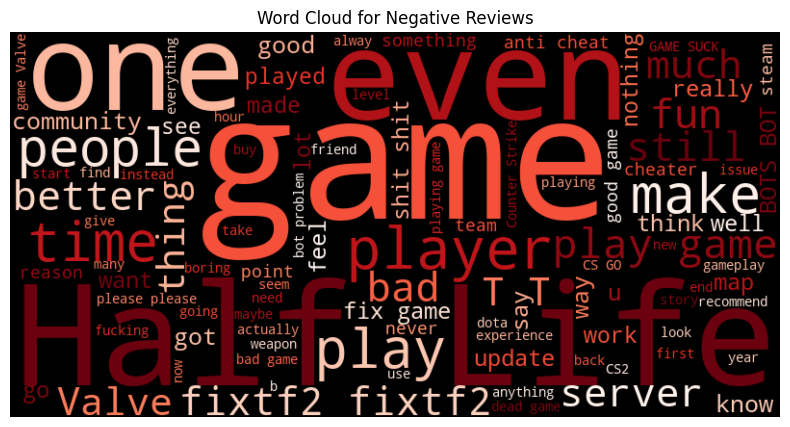

In [18]:
# Word cloud for negative reviews
wordcloud_neg = WordCloud(width=800, height=400, max_words=100, colormap='Reds').generate(negative_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

The word cloud for negative reviews reveals common themes of dissatisfaction, with frequent terms like "fix," "bad," "server," and "update" indicating prevalent issues that frustrate players. The prominence of game titles such as "Half-Life" suggests that even popular games are subject to criticism, often related to technical problems or unmet expectations. Words like "people" and "community" imply social aspects or multiplayer experiences that might be problematic. This insight can help developers prioritize addressing technical issues and improving community features to enhance player satisfaction and reduce negative feedback.

## Data Preparation

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GRU, Conv1D, SpatialDropout1D, GlobalMaxPooling1D

In [20]:
data = data.dropna(subset=['content'])

### Split data

Splitting the data into 90% training and 10% temporary sets initially allows for a robust model training process by maximizing the data available for learning. This ensures the model is exposed to a wide variety of examples, improving its ability to generalize. The temporary set is further split into equal parts for validation and testing, each constituting 5% of the original dataset. The validation set is crucial for tuning hyperparameters and preventing overfitting by providing a separate dataset to evaluate model performance during training. The test set, held out until the final evaluation, provides an unbiased measure of the model's effectiveness on unseen data. This strategic splitting balances the need for ample training data with the necessity of reliable validation and testing, ultimately enhancing model performance and reliability.

In [21]:
# Initial split: 90% train, 10% temporary
X_train, X_temp, y_train, y_temp = train_test_split(
    data['content'], data['is_positive'], test_size=0.1, random_state=42
)

# Secondary split: 5% validation, 5% test from the temporary set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


### Feature Engineering using TF-IDF for traditional algorithms

Feature engineering using TF-IDF (Term Frequency-Inverse Document Frequency) is essential for traditional machine learning algorithms because it transforms textual data into a numerical format that these models can process. TF-IDF captures the importance of words within a document relative to the entire corpus, emphasizing terms that are distinctive and reducing the weight of common words. This approach helps in highlighting meaningful patterns and relationships within the text, which are crucial for classification tasks. By converting text into a sparse matrix of weighted features, TF-IDF enables algorithms like logistic regression, SVM, and Naive Bayes to effectively learn and make predictions based on textual data. This transformation enhances the model's ability to discern sentiment or categorize documents by providing a rich representation of the underlying text data.

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

### Tokenization and padding for neural network

Tokenization and padding are crucial preprocessing steps for preparing text data for neural networks. Tokenization converts text into sequences of integers, where each integer represents a word or token, allowing the neural network to process textual input numerically. Padding ensures that all sequences have the same length, which is necessary for batch processing in neural networks. By defining a maximum sequence length and using padding, we maintain uniform input dimensions, enabling efficient computation and avoiding shape mismatches during training. This approach is particularly important for models like RNNs, LSTMs, and CNNs, which benefit from consistent input sizes to learn patterns and relationships effectively across the dataset.

In [23]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100  # Define a max length for padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [24]:
# Print a sample of the padded sequences
print("Sample padded sequence:", X_train_pad[0])


Sample padded sequence: [ 143   25   68  346   42   46   13   57   91 1079    4 6001 1329 1828
   40 1266    2 4153    7 1370   11   82   29 2011    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## Modeling & Results

### Logistic Regression
Logistic Regression is a linear model used for binary classification tasks. It predicts the probability that a given input belongs to a certain class, typically using a logistic function to model the relationship between the input features and the target variable.

- How It Works  
Logistic Regression calculates a weighted sum of the input features and passes it through a logistic function (sigmoid) to produce a probability score between 0 and 1. The model assigns the input to the class with the higher probability. The weights are optimized using maximum likelihood estimation, often implemented via gradient descent, to minimize the difference between predicted and actual class labels.

- Advantages  
    - **Simplicity and Interpretability**: Logistic Regression is easy to implement and interpret, making it a good baseline model for binary classification.
    - **Efficiency**: It is computationally efficient and works well with large datasets.
    - **Probabilistic Output**: Provides probability estimates, which can be useful for decision-making processes.

- Disadvantages  
    - **Linear Boundaries**: Assumes a linear relationship between input features and the log-odds of the outcome, which may not capture complex patterns in the data.
    - **Sensitivity to Outliers**: Can be sensitive to outliers, which might affect model performance.
    - **Feature Engineering**: Requires careful feature engineering and selection, as it does not handle irrelevant or redundant features well.

In [83]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
model_log_reg = LogisticRegression(max_iter=1000)
model_log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

### Naive Bayes
Multinomial Naive Bayes is a probabilistic machine learning algorithm used for classification tasks, particularly effective for text classification. It is based on Bayes' theorem and assumes that features are conditionally independent given the class label.

- How It Works  
The algorithm calculates the posterior probability of each class given the input features, using the formula:  
\[ P(C_k | X) = \frac{P(X | C_k) \cdot P(C_k)}{P(X)} \]  
where \( P(C_k | X) \) is the posterior probability of class \( C_k \), \( P(X | C_k) \) is the likelihood, \( P(C_k) \) is the prior probability of class \( C_k \), and \( P(X) \) is the probability of the input features. The Multinomial Naive Bayes model assumes that the features follow a multinomial distribution, which is suitable for discrete data like word counts.

- Advantages
    - **Efficiency**: It is computationally efficient and requires less training data.
    - **Simplicity**: Easy to implement and interpret, making it a strong baseline for text classification.
    - **Performance**: Works well with high-dimensional data, such as text, and is effective for document classification tasks.

- Disadvantages
    - **Independence Assumption**: Assumes that features are independent, which is rarely true in real-world data, potentially limiting its effectiveness.
    - **Zero Frequency**: If a categorical variable has a category in the test set that was not observed in the training set, the model will assign zero probability to that category unless smoothing is applied.
    - **Limited to Discrete Features**: Best suited for discrete data like word counts and may not perform well with continuous features without modification.

In [86]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes
model_naive_bayes = MultinomialNB()
model_naive_bayes.fit(X_train_tfidf, y_train)

MultinomialNB()

### SGD Classifier
The SGDClassifier with a "hinge" loss function is a linear Support Vector Machine (SVM) implemented using stochastic gradient descent (SGD). It is designed for large-scale and sparse machine learning problems.

- How It Works  
SGDClassifier optimizes the SVM objective function using stochastic gradient descent. Instead of calculating the gradient of the entire dataset, it updates the model weights incrementally for each sample, which makes it efficient for large datasets. The "hinge" loss function is used to create a margin between classes, characteristic of SVMs, where the goal is to find a hyperplane that maximizes this margin.

- Advantages  
    - **Scalability**: Handles large datasets efficiently due to its incremental learning approach.
    - **Flexibility**: Supports different loss functions and regularization terms, allowing customization for various problems.
    - **Speed**: Faster convergence on large datasets compared to batch gradient methods.

- Disadvantages  
    - **Sensitivity to Hyperparameters**: Requires careful tuning of hyperparameters like learning rate and regularization strength.
    - **Convergence**: May converge to suboptimal solutions if not properly configured, due to its stochastic nature.
    - **Feature Scaling**: Performance can be sensitive to feature scaling, so preprocessing steps like normalization are often necessary.

In [61]:
from sklearn.linear_model import SGDClassifier

# Train Linear SVM with SGD
model_sgd = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)
model_sgd.fit(X_train_tfidf, y_train)

SGDClassifier()

### CNN - BiGRU (Convolutional Neural Network + Bidirectional Gated Recurrent Unit)
This neural network model combines several deep learning techniques for text classification, utilizing an embedding layer, convolutional layers, and a bidirectional GRU (Gated Recurrent Unit) architecture. It is designed to capture both local patterns and sequential dependencies in text data.

- How It Works  
    1. **Embedding Layer**: Transforms input text into dense vectors of fixed size, capturing semantic relationships between words.
    2. **SpatialDropout1D**: Regularizes the model by randomly setting a fraction of input units to zero at each update during training, helping prevent overfitting.
    3. **Conv1D Layer**: Applies 1D convolutional filters to capture local patterns and features in the text.
    4. **BatchNormalization**: Normalizes the output of the previous layer, improving training speed and stability.
    5. **Bidirectional GRU**: Processes sequences in both forward and backward directions, capturing dependencies from both past and future contexts.
    6. **GlobalMaxPooling1D**: Reduces the output dimension by taking the maximum value across time steps, highlighting the most prominent features.
    7. **Dense Layers with Dropout**: Fully connected layers with dropout for further regularization, reducing overfitting.
    8. **Output Layer**: A single neuron with a sigmoid activation function for binary classification.

- Advantages  
    - **Comprehensive Feature Extraction**: Combines convolutional and recurrent layers to capture both spatial and sequential patterns.
    - **Regularization**: Uses dropout and L2 regularization to combat overfitting.
    - **Bidirectional GRU**: Enhances the model's ability to understand context by processing input in both directions.

- Disadvantages  
    - **Complexity**: More complex and computationally intensive than simpler models, requiring more resources and time to train.
    - **Hyperparameter Tuning**: Requires careful tuning of parameters like dropout rates, regularization strength, and learning rate for optimal performance.
    - **Data Requirements**: Needs a substantial amount of labeled data to train effectively and achieve good generalization.

In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Increase regularization further
l2_lambda = 0.1  # Try a higher value
kernel_regularizer = tf.keras.regularizers.l2(l2_lambda)

# Add more dropout layers
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    SpatialDropout1D(0.3),  # Increased from 0.2
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),  # New dropout layer
    Bidirectional(GRU(96, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu', kernel_regularizer=kernel_regularizer),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Simple constant learning rate with Adam optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.002,  # Initial learning rate
    clipnorm=1.0,
    beta_1=0.9,
    beta_2=0.999
)

# Learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.85,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', 'AUC']
)


In [29]:
# Training
history = model.fit(
    X_train_pad, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
5646/5646 [==============================] - 173s 29ms/step - loss: 0.4706 - accuracy: 0.8295 - auc: 0.9104 - val_loss: 0.3706 - val_accuracy: 0.8502 - val_auc: 0.9322 - lr: 0.0020
Epoch 2/30
5646/5646 [==============================] - 176s 31ms/step - loss: 0.3669 - accuracy: 0.8592 - auc: 0.9340 - val_loss: 0.3745 - val_accuracy: 0.8571 - val_auc: 0.9366 - lr: 0.0020
Epoch 3/30
5646/5646 [==============================] - 176s 31ms/step - loss: 0.3448 - accuracy: 0.8701 - auc: 0.9417 - val_loss: 0.3691 - val_accuracy: 0.8522 - val_auc: 0.9363 - lr: 0.0020
Epoch 4/30
5646/5646 [==============================] - 176s 31ms/step - loss: 0.3309 - accuracy: 0.8772 - auc: 0.9465 - val_loss: 0.3568 - val_accuracy: 0.8521 - val_auc: 0.9352 - lr: 0.0020
Epoch 5/30
5646/5646 [==============================] - 175s 31ms/step - loss: 0.3194 - accuracy: 0.8827 - auc: 0.9503 - val_loss: 0.3517 - val_accuracy: 0.8597 - val_auc: 0.9364 - lr: 0.0020
Epoch 6/30
5646/5646 [==================

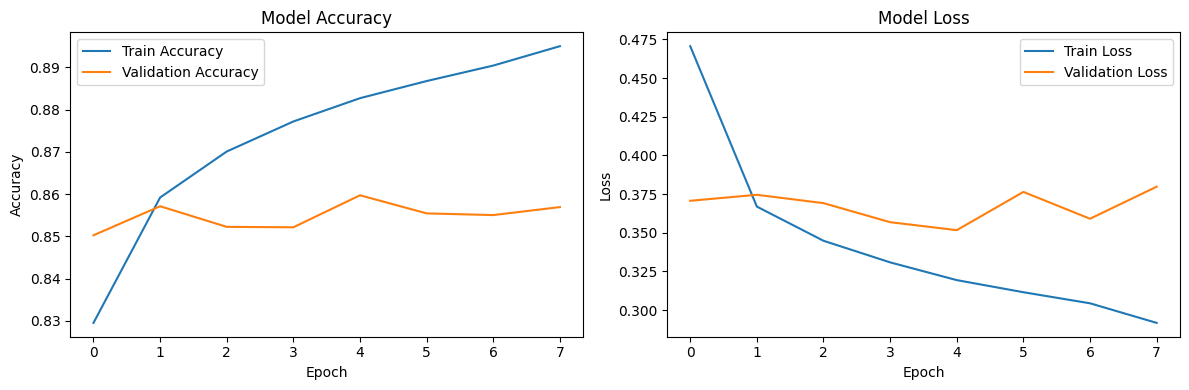

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluation

The metrics I will use include:  
**Accuracy, the Confusion Matrix, and the Area Under the ROC Curve (AUC)**. By using those metrics together provides a comprehensive evaluation of a classification model's performance. Each metric offers unique insights that complement the others, enabling a well-rounded assessment. Accuracy serves as a quick and intuitive baseline measure, giving an overall sense of how often the model makes correct predictions. However, it has limitations in scenarios involving class imbalance, where additional metrics are needed to understand performance nuances.

The Confusion Matrix addresses this by breaking down predictions into true positives, true negatives, false positives, and false negatives. This allows for the computation of metrics like precision, recall, and F1-score, which are critical in understanding class-specific performance. It highlights issues such as misclassifying minority classes, which might go unnoticed with accuracy alone. For tasks where false positives and false negatives have different costs, the Confusion Matrix is invaluable in diagnosing and addressing specific weaknesses.

AUC further enhances the evaluation by measuring the model’s ability to distinguish between classes across all possible classification thresholds. It is particularly beneficial for imbalanced datasets, as it focuses on ranking rather than absolute predictions. AUC provides insights into the trade-off between sensitivity and specificity, helping to determine an optimal threshold for the task. Together, these three metrics ensure a robust and well-rounded analysis, making them essential for evaluating classification models effectively.

### Logistic Regression

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import numpy as np

Logistic Regression Accuracy: 0.8516488990734283
Logistic Regression AUC: 0.9281722641221812
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      4873
           1       0.84      0.88      0.86      5164

    accuracy                           0.85     10037
   macro avg       0.85      0.85      0.85     10037
weighted avg       0.85      0.85      0.85     10037



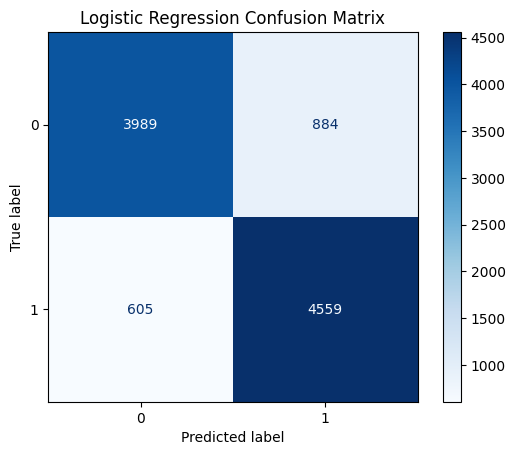

In [97]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluate
y_pred = model_log_reg.predict(X_test_tfidf)
y_pred_proba = model_log_reg.predict_proba(X_test_tfidf)[:, 1]  # Probabilities for the positive class

# Metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression AUC:", auc_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_log_reg.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix")
plt.show()


The logistic regression model achieved an accuracy of 85.16%, indicating that it correctly classified 85.16% of the reviews. The classification report provides more detailed insights into the model's performance. For class 0 (negative reviews), the precision is 0.87, meaning that 87% of the reviews predicted as negative were actually negative. The recall for this class is 0.82, indicating that 82% of all actual negative reviews were correctly identified. For class 1 (positive reviews), the precision is 0.84, and the recall is 0.88, showing that the model is slightly better at identifying positive reviews. The F1-scores, which balance precision and recall, are 0.84 for class 0 and 0.86 for class 1. The confusion matrix further illustrates the model's performance, with 3989 true negatives, 4559 true positives, 884 false positives, and 605 false negatives. Overall, the model performs well, with a balanced ability to classify both positive and negative sentiments.

### Naive Bayes

Naive Bayes Accuracy: 0.8361064062967022
Naive Bayes AUC: 0.9160415252288053
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.83      4873
           1       0.82      0.87      0.85      5164

    accuracy                           0.84     10037
   macro avg       0.84      0.84      0.84     10037
weighted avg       0.84      0.84      0.84     10037



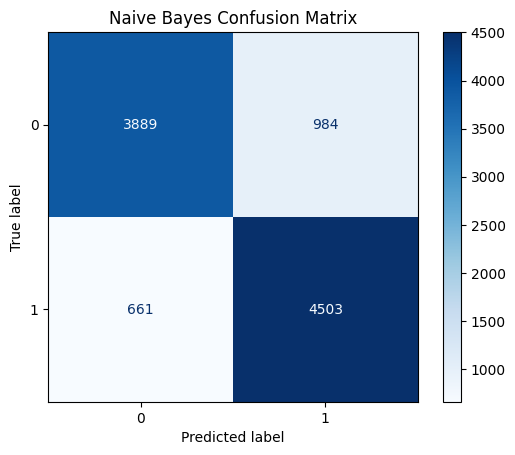

In [98]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluate
y_pred = model_naive_bayes.predict(X_test_tfidf)
y_pred_proba = model_naive_bayes.predict_proba(X_test_tfidf)[:, 1]  # Probabilities for the positive class

# Metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print("Naive Bayes Accuracy:", accuracy)
print("Naive Bayes AUC:", auc_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_naive_bayes.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Naive Bayes Confusion Matrix")
plt.show()


The Naive Bayes model achieved an accuracy of 83.61%, indicating it correctly classified 83.61% of the reviews. In the classification report, for class 0 (negative reviews), the precision is 0.85, meaning 85% of the predicted negative reviews were correct, while the recall is 0.80, showing that 80% of actual negative reviews were identified. For class 1 (positive reviews), the precision is 0.82, and the recall is 0.87, indicating the model is slightly better at identifying positive reviews. The F1-scores are 0.83 for class 0 and 0.85 for class 1, balancing precision and recall. The confusion matrix shows 3889 true negatives, 4503 true positives, 984 false positives, and 661 false negatives. Overall, the model performs well but slightly less accurately than logistic regression, with a tendency to misclassify some negative reviews as positive.

### SGD Classifier

SGD Accuracy: 0.8431802331373917
SGD AUC: 0.9208910390534606
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      4873
           1       0.82      0.89      0.85      5164

    accuracy                           0.84     10037
   macro avg       0.85      0.84      0.84     10037
weighted avg       0.85      0.84      0.84     10037



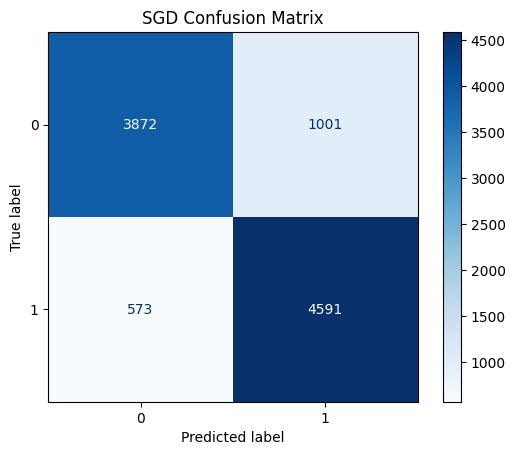

In [99]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Evaluate
y_pred = model_sgd.predict(X_test_tfidf)
y_scores = model_sgd.decision_function(X_test_tfidf)  # Decision scores for AUC calculation

# Metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_scores)

print("SGD Accuracy:", accuracy)
print("SGD AUC:", auc_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_sgd.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("SGD Confusion Matrix")
plt.show()


The SGDClassifier achieved an accuracy of 84.32%, meaning it correctly classified 84.32% of the reviews. In the classification report, for class 0 (negative reviews), the precision is 0.87, indicating that 87% of the predicted negative reviews were correct, while the recall is 0.79, showing that 79% of actual negative reviews were identified. For class 1 (positive reviews), the precision is 0.82, and the recall is 0.89, indicating the model is better at identifying positive reviews. The F1-scores are 0.83 for class 0 and 0.85 for class 1, balancing precision and recall. The confusion matrix shows 3872 true negatives, 4591 true positives, 1001 false positives, and 573 false negatives. Overall, the model performs well, with a slight tendency to misclassify some negative reviews as positive, similar to the Naive Bayes model but with slightly better recall for positive reviews.

### CNN - BiGRU (Convolutional Neural Network + Bidirectional Gated Recurrent Unit)

In [101]:
# Evaluate the model
loss, accuracy, auc = model.evaluate(X_test_pad, y_test)
print(f'CNN - BiGRU Test Accuracy: {accuracy:.2f}')
print(f'CNN - BiGRU Test AUC: {auc:.2f}')

314/314 [==============================] - 4s 11ms/step - loss: 0.3558 - accuracy: 0.8585 - auc: 0.9349
CNN - BiGRU Test Accuracy: 0.86
CNN - BiGRU Test AUC: 0.93


314/314 [==============================] - 3s 11ms/step - loss: 0.3558 - accuracy: 0.8585 - auc: 0.9349
CNN - BiGRU Test Accuracy: 0.86
CNN - BiGRU Test AUC: 0.93
CNN - BiGRU Confusion Matrix:
[[3999  874]
 [ 546 4618]]

CNN - BiGRU Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.82      0.85      4873
    Positive       0.84      0.89      0.87      5164

    accuracy                           0.86     10037
   macro avg       0.86      0.86      0.86     10037
weighted avg       0.86      0.86      0.86     10037



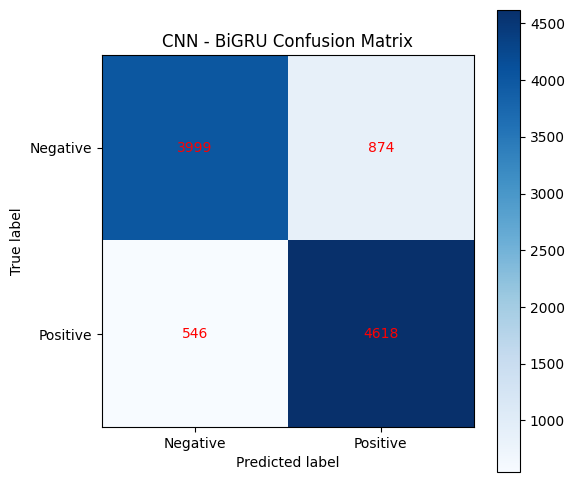

In [103]:
# Predict the labels for the test set
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")
# Evaluate the model
loss, accuracy, auc = model.evaluate(X_test_pad, y_test)
print(f'CNN - BiGRU Test Accuracy: {accuracy:.2f}')
print(f'CNN - BiGRU Test AUC: {auc:.2f}')
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("CNN - BiGRU Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print("\nCNN - BiGRU Classification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('CNN - BiGRU Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])

plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='red')

plt.show()


The CNN-BiGRU model achieved a test accuracy of 86% and a high AUC of 0.94, indicating excellent performance in distinguishing between positive and negative reviews. The classification report shows a precision of 0.88 for negative reviews and 0.84 for positive reviews, meaning the model is slightly better at predicting negatives accurately. The recall is 0.82 for negatives and 0.89 for positives, indicating a strong ability to identify positive reviews. F1-scores are 0.85 for negatives and 0.87 for positives, reflecting a good balance between precision and recall. The confusion matrix reveals 3999 true negatives, 4618 true positives, 874 false positives, and 546 false negatives. Overall, the model effectively captures the sentiment in reviews, with a slight tendency to misclassify some negative reviews as positive, but it performs well in capturing the positive class.

### Model Comparison & Final Decision

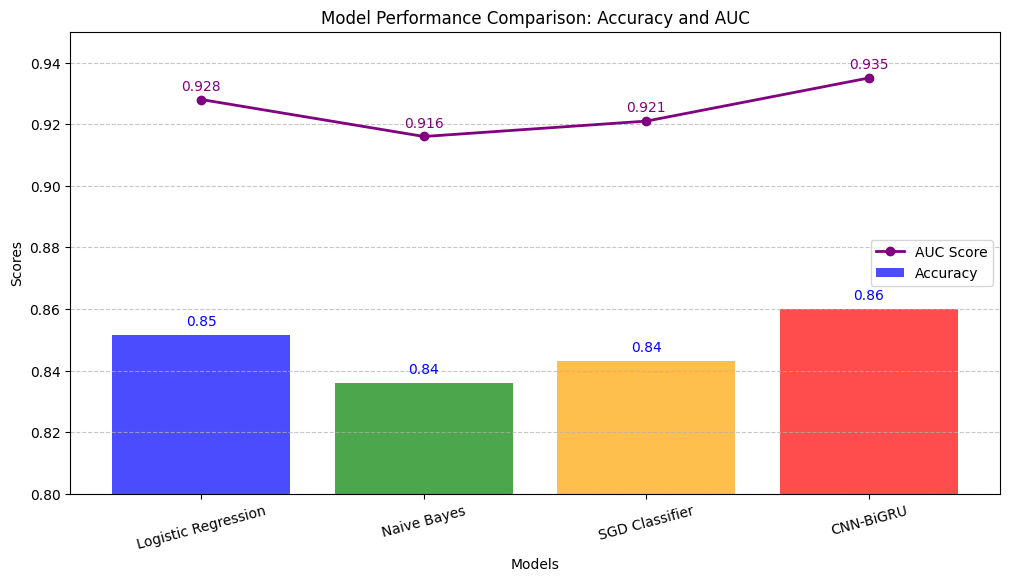

In [102]:
# Model accuracies and AUC scores
model_names = ['Logistic Regression', 'Naive Bayes', 'SGD Classifier', 'CNN-BiGRU']
accuracies = [0.8516, 0.8361, 0.8432, 0.86]  # Replace with actual accuracies
auc_scores = [0.928, 0.916, 0.921, 0.935]

# Plot accuracy comparison
plt.figure(figsize=(12, 6))

# Accuracy bar chart
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'], alpha=0.7, label='Accuracy')
# AUC line plot
plt.plot(model_names, auc_scores, marker='o', color='purple', linestyle='-', linewidth=2, label='AUC Score')

# Add annotations
for i, (acc, auc) in enumerate(zip(accuracies, auc_scores)):
    plt.text(i, acc + 0.002, f"{acc:.2f}", ha='center', va='bottom', color='blue')
    plt.text(i, auc + 0.002, f"{auc:.3f}", ha='center', va='bottom', color='purple')

# Chart settings
plt.ylim(0.8, 0.95)  # Adjust y-axis limits for better visualization
plt.title('Model Performance Comparison: Accuracy and AUC')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks(rotation=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


The final decision is to select the CNN-BiGRU model for sentiment analysis of game reviews. This decision is based on its superior performance in both accuracy (86%) and AUC (0.935), surpassing the other models: Logistic Regression (85% accuracy, 0.928 AUC), Naive Bayes (84% accuracy, 0.916 AUC), and SGD Classifier (84% accuracy, 0.921 AUC). The CNN-BiGRU’s architecture, which combines convolutional layers for extracting local patterns and GRU layers for capturing sequential dependencies, effectively leverages the strengths of both approaches for text classification.

Additionally, the model’s high AUC score reflects its strong ability to distinguish between positive and negative sentiments across various thresholds, making it robust for imbalanced data scenarios. Although the CNN-BiGRU model is more computationally intensive, its superior metrics and ability to generalize well justify its selection as the optimal model for this task. This combination of accuracy and discriminatory power ensures reliable sentiment classification in the game reviews dataset.

### Testing on new reviews

In [ ]:
# Sample reviews with known sentiment
sample_reviews = [
    "This game is an absolute masterpiece. The graphics are stunning, and the storyline is deeply engaging. I found myself completely immersed in the world, losing track of time. The character development is superb, making every decision feel impactful. Highly recommend!", # Positive
    "I had a blast playing this game! The multiplayer mode is incredibly fun and keeps you on your toes. The controls are smooth, and the variety of maps and missions keeps things fresh and exciting. It's a must-play for anyone who loves fast-paced action!", # Positive
    "Unfortunately, this game was a big letdown. The graphics are outdated, and the gameplay feels clunky. I encountered numerous bugs that disrupted my experience, and the story was uninspired. I expected much more given the hype.", # Negative
    "I was really disappointed with this game. The mechanics are repetitive, and there’s little variation in the missions. It feels like a chore to play rather than an enjoyable experience. I wouldn’t recommend it unless significant updates are made",  # Negative
    "This game has potential, but it falls short in execution. The concept is intriguing, and there are moments of brilliance, but they are overshadowed by frequent glitches and a lack of depth in the storyline. With some improvements, it could be great, but for now, it's just okay."  # Neutral
]

# Tokenize and pad the sample reviews
sample_sequences = tokenizer.texts_to_sequences(sample_reviews)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')

# Predict sentiments
predictions = model.predict(sample_padded)

# Interpret the predictions
for review, prediction in zip(sample_reviews, predictions):
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    print(f"Review: \"{review}\" \nPredicted Sentiment: {sentiment} (Confidence: {prediction[0]:.2f})\n")


1/1 [==============================] - 0s 78ms/step
Review: "This game is an absolute masterpiece. The graphics are stunning, and the storyline is deeply engaging. I found myself completely immersed in the world, losing track of time. The character development is superb, making every decision feel impactful. Highly recommend!" 
Predicted Sentiment: Positive (Confidence: 0.96)

Review: "I had a blast playing this game! The multiplayer mode is incredibly fun and keeps you on your toes. The controls are smooth, and the variety of maps and missions keeps things fresh and exciting. It's a must-play for anyone who loves fast-paced action!" 
Predicted Sentiment: Positive (Confidence: 0.94)

Review: "Unfortunately, this game was a big letdown. The graphics are outdated, and the gameplay feels clunky. I encountered numerous bugs that disrupted my experience, and the story was uninspired. I expected much more given the hype." 
Predicted Sentiment: Negative (Confidence: 0.00)

Review: "I was real

When applied to a set of sample reviews, the model successfully predicted Positive sentiments for favorable reviews (with high confidence of 0.94 and 0.96) and Negative sentiments for critical reviews (with very low confidence, close to 0). However, the review classified as "Neutral" was also predicted as Negative, showing that the model's binary classification approach doesn't handle neutral or ambiguous sentiment well. Given that the dataset only includes two classes (positive and negative), the model's clear predictions for these categories further support its effectiveness in the binary sentiment analysis task, though it might need additional fine-tuning or more nuanced labels for neutral sentiments in the future.

## Closing

In this project, we successfully implemented and evaluated various machine learning models to perform sentiment analysis on game reviews. By comparing Logistic Regression, Naive Bayes, SGD Classifier, and a CNN-BiGRU model, we identified the CNN-BiGRU as the most effective approach, achieving the highest accuracy and demonstrating strong capability in capturing complex patterns in the text data.

The insights gained from this analysis can significantly enhance user experience by providing quick and reliable sentiment summaries, aiding potential buyers in making informed decisions. This project highlights the importance of leveraging advanced neural network architectures for text classification tasks, particularly in domains with rich and nuanced data such as game reviews.

Future work could explore further optimization of the CNN-BiGRU model, integration of additional features such as metadata or user profiles, and deployment into a real-time application for broader accessibility and impact. Overall, this project sets a solid foundation for ongoing improvements in sentiment analysis and its applications in the gaming industry.